# Detecting hot posts by classification

1. 目的：我們收到社群輿論資料共一萬多筆貼文（posts），想要從裡面建立一個分類模型來偵測什麼樣的貼文會「爆」（假設某則post有超過100則回文（comments），以PTT的語彙來說，就是爆了）。
2. 依變項（Dependent）：依變項為每則posts的回文數，把100則回文以上的文章視為1，把少於100則回文的視為0（切勿不可將回文數當成自變項，如果這麼做就會被扣很多分數）。但你也可以嘗試以不一樣的方式去切割，但要注意盡可能保持1/0兩個分類貼文數的平衡。
3. 自變項（Independent）：至少要以貼文內容作為自變項，但可以用貼文標題、貼文作者、貼文時間來訓練。除此之外，我們還提供了前10則回文，說不定影響一則貼文會不會爆的主要因素是前十則回文。你可以自己決定要不要把回文丟下去當自變項。本作業的要求只有要求要用貼文當自變項。
4. 參考版本：助教用simpletransformer寫了個[版本](https://colab.research.google.com/drive/1YQZNlzH_mo7_Q3XU8X2sIpkhrQZWVYar?usp=sharing)給各位參考，但作為示範助教僅使用了貼文內容作為特徵來訓練模型、也使用了較少的資料集（在時間上做了點切割）。你可以使用全部的貼文來預測，或者可以嘗試加入每則貼文的前10則回文來預測。


In [1]:
import pandas as pd
import numpy as np
import jieba
import unicodedata
import re

# 讀取資料
1. 貼文資料https://github.com/p4css/PSS/blob/master/data/ptt_post.pickle
2. 回文資料https://github.com/p4css/PSS/blob/master/data/ptt_comment10.pickle 
貼文與相對應的回文資料均以plink作為key，可以用pandas的merge將兩個資料集給連結起來做訓練。但要怎麼把前十則的回文化為貼文特徵，要想想。

In [2]:
df1 = pd.read_pickle("../data/ptt_post.pickle")
df2 = pd.read_pickle("../data/ptt_comment10.pickle")

## 資料標記

In [3]:
df1['pcontent'] = df1.pcontent.apply(lambda x: re.sub(r'\n+', '\n', x).strip())
df1['pcontent'] = df1.pcontent.apply(lambda x: x.replace('\u3000', ''))
df1['pcontent'] = df1.pcontent.apply(lambda x: x.replace('\n', ' ').replace(r'(www|http:|https:)+[^\s]+[\w]', ' ').strip())
df1['labels'] = pd.cut(df1.Ncomment, bins=[-np.inf, 100, np.inf], labels=[0, 1])
print(df1.labels.value_counts())
df1.head(5)

1    6274
0    5875
Name: labels, dtype: int64


,plink,board,pcontent,poster,ptitle,ptime,ipaddr,ip.len,Ncomment,labels
0,https://www.ptt.cc/bbs/Gossiping/M.1119222660....,Gossiping,"看到這推文,忍不住要寫一個飛機沒油的例子 很久之前在讀者文摘上看到,現憑印象寫文,有錯請指...",Muroi (I Honestly Love You),Re: (問題)華航空難留言,Mon Jun 20 07:28:27 2005,138.130.212.179,1,944,1
1,https://www.ptt.cc/bbs/Gossiping/M.1119233779....,Gossiping,那不是為了反盜版 那是為了捐錢給消基會 當年美國唱了 WE ARE THE WORLD之後 ...,JCC (JCC ),Re: 有沒有明天會更好的八卦,Mon Jun 20 10:21:53 2005,211.20.78.69,1,350,1
2,https://www.ptt.cc/bbs/Gossiping/M.1119257927....,Gossiping,我聽到的是： 記者問張跟路有沒有要結婚 家人有沒有在催。。。巴拉巴拉的 張覺得很煩，就回說 ...,vancie (我不正 我很歪 ),Re: [新聞] 張震月的八卦有嗎？,Mon Jun 20 17:07:13 2005,※ 發信站: 批踢踢實業坊(ptt.cc),0,156,1
3,https://www.ptt.cc/bbs/Gossiping/M.1119258686....,Gossiping,"太想被M,得到P幣 再八卦一下 桌伯元先生真的不是台大法學碩士 它是 國立台灣大學法律系學士...",J1 (andy),Re: [政商] 請問桌伯元的八卦?,Mon Jun 20 17:18:14 2005,220.141.159.23,1,160,1
4,https://www.ptt.cc/bbs/Gossiping/M.1119271499....,Gossiping,米其林是家輪胎公司 米其林兄弟發行了一本只送不賣的輪胎手冊 讓所有自動車 自行車 機車的車主...,ilcd (南特 巴黎 白朗峰!!! ),Re: 有沒有米其淋的美食還是什麼評鑑八卦,Mon Jun 20 20:53:24 2005,218.167.152.79,1,153,1


## 資料清理: 內文、標題

In [4]:
# 內文斷詞
df1['token_content'] = df1['pcontent'].apply(lambda x: list(jieba.cut(x)))

# 移除標點符號
def remove_punc_by_unicode(words):
    out = []
    for word in words:
        if word != " " and not unicodedata.category(word[0]).startswith('P'):
            out.append(word)
    return out

df1['cleaned_content'] = df1['token_content'].apply(remove_punc_by_unicode)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache
Loading model cost 2.203 seconds.
Prefix dict has been built successfully.


In [5]:
# 標題斷詞
df1['token_title'] = df1['ptitle'].astype('str').apply(lambda x: list(jieba.cut(x)))

# 移除標點符號
df1['cleaned_title'] = df1['token_title'].apply(remove_punc_by_unicode)

# 區別標題與內文
def distinguisher(words):
    out = []
    for word in words:
        out.append('Title' + word)
    return out
df1['cleaned_title'] = df1['cleaned_title'].apply(distinguisher)

In [6]:
df1.head(2)

,plink,board,pcontent,poster,ptitle,ptime,ipaddr,ip.len,Ncomment,labels,token_content,cleaned_content,token_title,cleaned_title
0,https://www.ptt.cc/bbs/Gossiping/M.1119222660....,Gossiping,"看到這推文,忍不住要寫一個飛機沒油的例子 很久之前在讀者文摘上看到,現憑印象寫文,有錯請指...",Muroi (I Honestly Love You),Re: (問題)華航空難留言,Mon Jun 20 07:28:27 2005,138.130.212.179,1,944,1,"[看到, 這推文, ,, 忍不住, 要, 寫, 一個, 飛機, 沒油, 的, 例子, , ...","[看到, 這推文, 忍不住, 要, 寫, 一個, 飛機, 沒油, 的, 例子, 很, 久, ...","[Re, :, , (, 問題, ), 華, 航空, 難, 留言]","[TitleRe, Title問題, Title華, Title航空, Title難, Ti..."
1,https://www.ptt.cc/bbs/Gossiping/M.1119233779....,Gossiping,那不是為了反盜版 那是為了捐錢給消基會 當年美國唱了 WE ARE THE WORLD之後 ...,JCC (JCC ),Re: 有沒有明天會更好的八卦,Mon Jun 20 10:21:53 2005,211.20.78.69,1,350,1,"[那, 不是, 為, 了, 反盜, 版, , 那, 是, 為, 了, 捐, 錢給, 消基會...","[那, 不是, 為, 了, 反盜, 版, 那, 是, 為, 了, 捐, 錢給, 消基會, 當...","[Re, :, , 有, 沒, 有, 明天, 會, 更好, 的, 八卦]","[TitleRe, Title有, Title沒, Title有, Title明天, Tit..."


In [7]:
contents = [" ".join(doc) for doc in df1['cleaned_content']]
titles = [" ".join(doc) for doc in df1['cleaned_title']]

document = []
for i in range(len(contents)):
    document.append(titles[i]+" "+contents[i])

## 建立變數

In [9]:
# Feature Selection: tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf
from sklearn.feature_selection import SelectKBest, chi2 # tf-idf with chi-squared

# Feature Selection: embedding
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import scipy

# Models
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression

# Pipeline
from sklearn.pipeline import Pipeline

# Model Selection
from sklearn.model_selection import GridSearchCV

In [8]:
X = document
Y = df1['labels']

In [41]:
with open("../data/stopwords_zh-tw.txt", encoding="utf-8") as fin:
    stopwords = fin.read().split("\n")[1:]

X_tfidf = TfidfVectorizer(max_df = 1.0, ngram_range = (1, 2), max_features = 20000, stop_words = stopwords).fit(X).transform(X)

# Parameter Selection with Grid and Pipline

## Pipeline Design

In [42]:
pipe1 = Pipeline([('chi2', SelectKBest(score_func=chi2)), 
                  ('logistic', LogisticRegression())])

pipe2 = Pipeline([('chi2', SelectKBest(score_func=chi2)), 
                  ('bayes', GaussianNB())])

pipe3 = Pipeline([('chi2', SelectKBest(score_func=chi2)), 
                  ('tree', GradientBoostingClassifier())])

In [51]:
parameters1 = {'chi2__k': [1000, 2000, 5000, 10000, 20000], 
               'logistic__solver': ['newton-cg', 'sag', 'lbfgs'], 
               'logistic__penalty': ('l2', 'none')}

parameters2 = {'chi2__k': [1000, 2000, 5000, 10000, 20000]}

parameters3 = {'chi2__k': [1000, 2000, 5000, 10000, 20000], 
               'tree__n_estimators': [100, 200, 500], 
               'tree__learning_rate': [0.05, 0.1, 0.2], 
               'tree__max_features': ["sqrt", "log2"]}

# 切割資料集

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf.toarray(), Y, test_size=0.3)

## 模型測試

### Logistic Regression

In [45]:
grid = GridSearchCV(pipe1, parameters1, cv=5, n_jobs=-1, verbose = 3).fit(X_train, Y_train)
grid

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('chi2',
                                        SelectKBest(score_func=<function chi2 at 0x000001A10F8B4DC0>)),
                                       ('logistic', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'chi2__k': [1000, 2000, 5000, 10000, 20000],
                         'logistic__penalty': ('l2', 'none'),
                         'logistic__solver': ['newton-cg', 'sag', 'lbfgs']},
             verbose=3)

In [46]:
print(grid.best_score_)
print("Params: ")
for param_name in sorted(parameters1.keys()):
    print("%s: %r" % (param_name, grid.best_params_[param_name]))

0.6892074558218348
Params: 
chi2__k: 20000
logistic__penalty: 'l2'
logistic__solver: 'newton-cg'


### Bayes Classifier

In [47]:
grid2 = GridSearchCV(pipe2, parameters2, cv=5, n_jobs=-1, verbose = 3).fit(X_train, Y_train)
grid2

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('chi2',
                                        SelectKBest(score_func=<function chi2 at 0x000001A10F8B4DC0>)),
                                       ('bayes', GaussianNB())]),
             n_jobs=-1,
             param_grid={'chi2__k': [1000, 2000, 5000, 10000, 20000]},
             verbose=3)

In [48]:
print(grid2.best_score_)
print("Params: ")
for param_name in sorted(parameters2.keys()):
    print("%s: %r" % (param_name, grid2.best_params_[param_name]))

0.6067705501953868
Params: 
chi2__k: 10000


### GradientBoosting

In [52]:
grid3 = GridSearchCV(pipe3, parameters3, cv=5, n_jobs=-1, verbose = 3).fit(X_train, Y_train)
grid3

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('chi2',
                                        SelectKBest(score_func=<function chi2 at 0x000001A10F8B4DC0>)),
                                       ('tree', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'chi2__k': [1000, 2000, 5000, 10000, 20000],
                         'tree__learning_rate': [0.05, 0.1, 0.2],
                         'tree__max_features': ['sqrt', 'log2'],
                         'tree__n_estimators': [100, 200, 500]},
             verbose=3)

In [53]:
print(grid3.best_score_)
print("Params: ")
for param_name in sorted(parameters3.keys()):
    print("%s: %r" % (param_name, grid3.best_params_[param_name]))

0.6924990835840508
Params: 
chi2__k: 2000
tree__learning_rate: 0.05
tree__max_features: 'sqrt'
tree__n_estimators: 500


# 訓練模型: final run

In [54]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def train_model(classifier, train, train_label, test, test_label):
    classifier.fit(train, train_label)
    pred_label = classifier.predict(test)
    print(confusion_matrix(test_label, pred_label))
    print(classification_report(test_label, pred_label))

In [55]:
# LR
X_logistic = SelectKBest(score_func=chi2, k=20000).fit_transform(X_tfidf, Y)
X_logistic_train, X_logistic_test, Y_logistic_train, Y_logistic_test = train_test_split(X_logistic.toarray(), Y, test_size=0.3)
train_model(LogisticRegression(penalty = 'l2', solver = 'newton-cg'), X_logistic_train, Y_logistic_train, X_logistic_test, Y_logistic_test)

[[1225  530]
 [ 544 1346]]
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      1755
           1       0.72      0.71      0.71      1890

    accuracy                           0.71      3645
   macro avg       0.70      0.71      0.71      3645
weighted avg       0.71      0.71      0.71      3645



In [56]:
# Bayes
X_bayes = SelectKBest(score_func=chi2, k=10000).fit_transform(X_tfidf, Y)
X_bayes_train, X_bayes_test, Y_bayes_train, Y_bayes_test = train_test_split(X_bayes.toarray(), Y, test_size=0.3)
train_model(GaussianNB(), X_bayes_train, Y_bayes_train, X_bayes_test, Y_bayes_test)

[[1253  505]
 [ 619 1268]]
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1758
           1       0.72      0.67      0.69      1887

    accuracy                           0.69      3645
   macro avg       0.69      0.69      0.69      3645
weighted avg       0.69      0.69      0.69      3645



In [57]:
# GradientBoosting
X_boosting = SelectKBest(score_func=chi2, k=2000).fit_transform(X_tfidf, Y)
X_boosting_train, X_boosting_test, Y_boosting_train, Y_boosting_test = train_test_split(X_boosting.toarray(), Y, test_size=0.3)
train_model(GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 500, max_features = 'sqrt'), X_boosting_train, Y_boosting_train, X_boosting_test, Y_boosting_test)

[[1220  564]
 [ 534 1327]]
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      1784
           1       0.70      0.71      0.71      1861

    accuracy                           0.70      3645
   macro avg       0.70      0.70      0.70      3645
weighted avg       0.70      0.70      0.70      3645



# 預測結果
預測結果應包含`classification_report`並應用`from mlxtend.plotting import plot_confusion_matrix`繪製confision_matrix的視覺化結果。

In [62]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

In [59]:
def evaluation(classifier, train, train_label, test, test_label):
    classifier.fit(train, train_label)
    pred_label = classifier.predict(test)
    print(classification_report(test_label, pred_label))
    return confusion_matrix(test_label, pred_label)

chi2 + Logistic Regression
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      1755
           1       0.72      0.71      0.71      1890

    accuracy                           0.71      3645
   macro avg       0.70      0.71      0.71      3645
weighted avg       0.71      0.71      0.71      3645



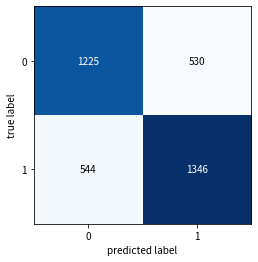

chi2 + Bayes Classifier
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1758
           1       0.72      0.67      0.69      1887

    accuracy                           0.69      3645
   macro avg       0.69      0.69      0.69      3645
weighted avg       0.69      0.69      0.69      3645



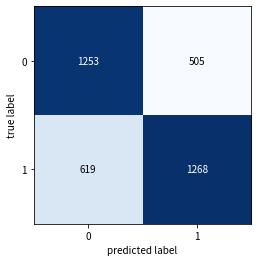

chi2 + GradientBoosting
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1784
           1       0.70      0.71      0.71      1861

    accuracy                           0.70      3645
   macro avg       0.70      0.70      0.70      3645
weighted avg       0.70      0.70      0.70      3645



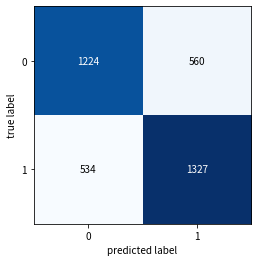

In [63]:
print("chi2 + Logistic Regression")
cm1 = evaluation(LogisticRegression(penalty = 'l2', solver = 'newton-cg'), X_logistic_train, Y_logistic_train, X_logistic_test, Y_logistic_test)
fig, ax = plot_confusion_matrix(conf_mat=cm1)
plt.show()
plt.close()
print("="*100)

print("chi2 + Bayes Classifier")
cm2 = evaluation(GaussianNB(), X_bayes_train, Y_bayes_train, X_bayes_test, Y_bayes_test)
fig, ax = plot_confusion_matrix(conf_mat=cm2)
plt.show()
plt.close()
print("="*100)

print("chi2 + GradientBoosting")
cm3 = evaluation(GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 500, max_features = 'sqrt'), X_boosting_train, Y_boosting_train, X_boosting_test, Y_boosting_test)
fig, ax = plot_confusion_matrix(conf_mat=cm3)
plt.show()
plt.close()
print("="*100)

# 分析預測結果
Q1. 你把什麼樣的特徵丟進去當自變項（最基本要有貼文，但你還可以丟貼文的發文者、時間、標題、前十則回文內容、回文作者）？
> 將標題、內文當作自變項，並將兩這併入同一個document中，在標題的文字中加上"Title"區別標題文字與內文文字。

Q2. 你認為這個模型的分類能力好嗎？請說明模型訓練結果。
> 我測的三個模型f-1 score都在7成上下(因為預測八卦爆不爆的效益不高，我認為7成雖不算高但可以接受)，recall rate以及precision rate也都在1-2%內。三個模型比較起來的話，是貝氏分類器的效果最差，Logistic Regression的效果跟GradientBoosting差不多。而Logistic Regression確實也在binary classification上表現較好(雖然‘newton-cg’較其他solver更專注處理multiclass的問題)。差別較大的地方在於三個模型適合的chi-square feature數，分別是羅吉斯20000、貝氏10000、決策數2000。

Q3. 你認為ptt貼文內容適合拿來做訓練資料嗎？為什麼？
> 不太適合，最初不使用tfidf轉換成sparse matrix的時候約有將近22萬個column。縱使之後配合chi-square去篩選適合的feature數量，每筆留言也可能因為八卦版的主題內容過於雜亂而讓每篇文章沒有代表性。

Q4. 若加入其他參考特徵後，模型有什麼樣的改變呢（如果你沒做的話就不用回答）？
> 我假設鄉民有受到標題影響的判斷的傾向，因此僅加入標題做為附加的參考特徵(一方面也是因為方便處理)。我認為這對於訓練結果會有改善，但可能不太顯著。原因在於標題跟內文都是文字資料，轉成tfidf後都是在算詞頻權重。加入發文時間可能會是個更強的參考特徵。

Q5. 如果你在Daily Scrum上要回報這個任務，請用100字以上、200字以內精簡且精準地回報模型訓練結果。
> 我對ptt八卦版的貼文內容進行爆的可能性預測，以文章標題跟內容作為自變項，目標使用tfidf跟chi-square對自變項進行篩選。在模型訓練上，將訓練資料與測試資料按七三的比例拆分，分別跑了效果較好的Logistic Regression、GradientBoosting，以及效果較差的Bayes Classifier。其中，預測是爆的文章中實際上也有70%是爆;真的是爆的文章中也有70%左右的比例真的被找出來。
> 將停詞移除、加入作者、發文時間應該能進一步提升模型的準確度，但該如何區別作者這個文字變項也要思考。